In [39]:
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats
import random
import warnings

In [43]:
warnings.filterwarnings('ignore')

In [109]:
# stiprows - It can be seen from the dataset that the actual genes matrix starts in line 59. 
df = pd.read_csv('AMI_GSE66360_series_matrix.csv',skiprows=59,header=None)

In [113]:
df = df.T
new_header = df.iloc[0]
df = df[1:]
df.columns = new_header

In [114]:
print(df.shape)
df.head()

(99, 54677)


,Class,ID_REF,1007_s_at,1053_at,117_at,121_at,1255_g_at,1294_at,1316_at,1320_at,...,AFFX-r2-Ec-bioD-3_at,AFFX-r2-Ec-bioD-5_at,AFFX-r2-P1-cre-3_at,AFFX-r2-P1-cre-5_at,AFFX-ThrX-3_at,AFFX-ThrX-5_at,AFFX-ThrX-M_at,AFFX-TrpnX-3_at,AFFX-TrpnX-5_at,AFFX-TrpnX-M_at
1,H,GSM1620819,5.866377893,8.22579012,6.17973231,6.179477974,2.792047952,9.290410779,6.998285145,5.348943925,...,13.2573,13.2662,14.5712,14.2766,4.50466,3.13933,2.74701,2.65155,3.41343,3.14061
2,H,GSM1620820,4.948736331,7.525865369,6.628137025,6.58288903,2.69571445,9.462275035,6.558214949,5.410884095,...,13.5939,13.517,14.7388,14.3412,4.40923,3.03996,2.63861,2.64362,3.39906,3.13269
3,H,GSM1620821,5.148384393,7.764636529,5.859151477,6.602134766,2.580181122,9.116776316,6.851622539,5.254073031,...,13.3728,13.4166,14.6272,14.3186,4.31008,3.22011,2.49526,2.62603,3.53997,3.6984
4,H,GSM1620822,5.064418945,7.198461482,5.974135101,6.545904723,2.712123845,9.134584186,7.357827486,5.242139865,...,13.4902,13.4948,14.7541,14.3633,4.43931,3.26378,2.5442,2.50496,3.39623,3.63861
5,H,GSM1620823,5.017832878,7.831450258,6.793079158,5.911542321,2.723686912,9.582343511,7.283872601,5.219483996,...,13.2368,13.3302,14.5484,14.2637,4.56288,3.13852,2.50663,2.60971,3.43472,3.57765


In [ ]:
############
##DONT RUN THIS!!!!!!!!!!!!

In [120]:
df[df.columns[2:]] = df[df.columns[2:]].apply(lambda x: x.astype("float"))

In [121]:
df.dtypes

0
Class               object
ID_REF              object
1007_s_at          float64
1053_at            float64
117_at             float64
                    ...   
AFFX-ThrX-5_at     float64
AFFX-ThrX-M_at     float64
AFFX-TrpnX-3_at    float64
AFFX-TrpnX-5_at    float64
AFFX-TrpnX-M_at    float64
Length: 54677, dtype: object

In [118]:
# s = df[df.columns[2:]].select_dtypes(include='object').columns
# df[s] = df[s].astype("float")

In [ ]:
df.dtypes

## Analysis:

A part: 

Q.1 How many genes profiled? 

In [52]:
print(f"{df.shape[1]-2} genes were profiled in this dataset")

54675 genes were profiled in this dataset


Q.2 How many samples (subjects/patients) in total?

In [53]:
print(f"{df.shape[0]} samples in total")

99 samples in total


Q.3 How many samples in each class?


In [57]:
print("Distrobution of the samples per class:")
df['Class'].value_counts()

Distrobution of the samples per class:


H    50
M    49
Name: Class, dtype: int64

Q.4 If there are missing values, then remove the entire row (gene) from the data matrix. How many rows left now?

In [61]:
df.isna().sum().sort_values(ascending=False)

0
221247_s_at     1
204101_at       1
1565765_x_at    1
1552508_at      1
218117_at       1
               ..
227194_at       0
227193_at       0
227192_at       0
227191_at       0
Class           0
Length: 54677, dtype: int64

In [64]:
df.dropna(axis=1, inplace=True)

In [66]:
print(f"{df.shape[1]} genes left")

54630 genes left


Q.5 Pick 20 genes at random. Draw 20 pair boxplots in one figure comparing expression levels of each of these genes in the two classes M and H.

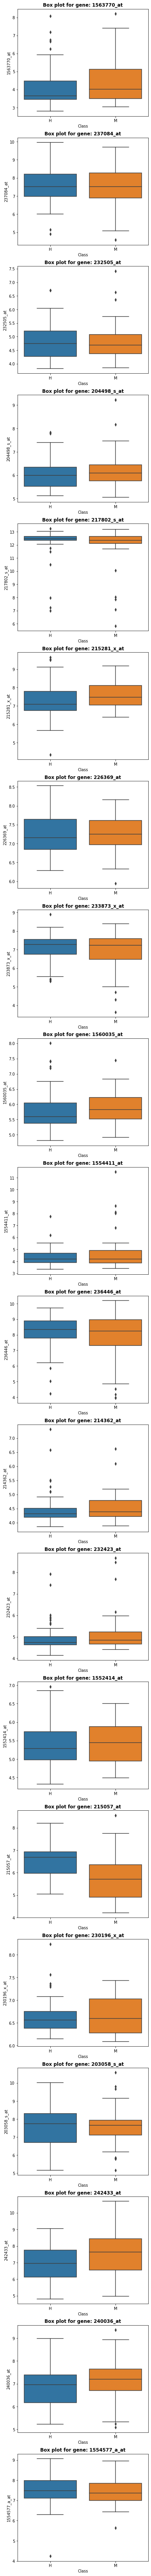

In [157]:
random.seed(1)
random_genes = random.choices(df.columns[2:],k=20)

fig, ax = plt.subplots(nrows=20, figsize=(6,120))

for i, col in enumerate(random_genes):
    axes = sns.boxplot(x='Class', y=df[col], data=df, ax=ax[i])
    axes.set_title(f"Box plot for gene: {col}", fontweight='bold',size=12)


B part: 

Q1. Consider some gene, g. Under the null model (which assumes that for g there is no M vs H DE), what is the expected sum of ranks of g’s expression levels measured for samples labeled M?

B $\rightarrow$ The labeled group M
<br>$E(T) = \frac{B(N+1)}{2} = \frac{49 \cdot (99+1)}{2} = 2450$

Q2. Denote this sum of ranks by RS(g). What is the maximal value, c, that RS(g) can take?

In [155]:
sum_highest_ranks = sum(np.arange(51,100))
print(f"Maximal value, c, that RS(g) can take: {sum_highest_ranks}")

Maximal value, c, that RS(g) can take: 3675


Q3.  Under the null model, what is the probability of RS(g) = c? (Provide a formula for this and explain it)

The null model assumes that there is no difference between Healthy and Myocardial Infraction patients.
<br>Based on the the previous question, the rating for the disese patients has the highest values compared to the healthy ones who receive the low values.
<br>The sample space is N choose B where N=total patients, B=disease patients.
<br>c event can happend in only one configuration over the sample space.
<br>The p-value formula for this configuration is: $\frac{1}{N \choose B}$
<br>Therfore, the p-value of RS(g) = c under the null model is: $\frac{1}{99 \choose 49}$

Q4. Under the null model, what is the probability of RS(g) = c-1? what is the probability of RS(g) = c-2? (Provide formulas and explain them)

<u>Probability of RS(g) = c-1:</u>
<br>There is only one configuration to achive this result, by switching between ranks 50(healthy) and 51(diseased), so that the 51th will be healthy, and the 50th will be diseased.
<br>Therfore, there is only one configuration to do that replacement the probability will be:
$\frac{1}{99 \choose 49}$
<br><u>Probability of RS(g) = c-2:</u>
<br>There is two configurations to achive this result:
<ul>
    <li>switching between ranks 50(healthy) and 52(diseased), so that the 52th will be healthy, and the 50th will be diseased
        </li>
    <li>switching between ranks 49(healthy) and 51(diseased), so that the 51th will be healthy, and the 49th will be diseased.
        </li>
    </ul> 
<br>Therfore, there are two configurations to do that replacement so the probability will be:
$\frac{2}{99 \choose 49}$

Q5. Draw a histogram of the values of RS(g) in the dataset. Here g ranges over all genes in the data (after the clean-up). Compute the IQR for this distribution and present it on the plot with the histogram

,1007_s_at,1053_at,117_at,121_at,1255_g_at,1294_at,1316_at,1320_at,1405_i_at,1431_at,...,AFFX-r2-Ec-bioD-3_at,AFFX-r2-Ec-bioD-5_at,AFFX-r2-P1-cre-3_at,AFFX-r2-P1-cre-5_at,AFFX-ThrX-3_at,AFFX-ThrX-5_at,AFFX-ThrX-M_at,AFFX-TrpnX-3_at,AFFX-TrpnX-5_at,AFFX-TrpnX-M_at
1,66.0,88.0,20.0,22.0,44.0,71.0,75.0,37.0,68.0,80.0,...,19.0,23.0,21.0,20.0,32.0,17.0,31.0,30.0,11.0,4.0
2,8.0,42.0,43.0,61.0,19.0,80.0,41.0,48.0,37.0,25.0,...,49.0,56.0,33.0,29.0,16.0,8.0,14.0,27.0,9.0,3.0
3,21.0,60.0,4.0,65.0,3.0,59.0,68.0,25.0,48.0,91.0,...,32.0,40.0,28.0,27.0,6.0,25.0,2.0,24.0,42.0,46.0
4,16.0,23.0,10.0,59.0,26.0,62.0,90.0,23.0,74.0,47.0,...,43.0,52.0,35.0,30.0,20.0,29.0,8.0,5.0,8.0,42.0
5,12.0,65.0,51.0,6.0,33.0,86.0,88.0,20.0,43.0,76.0,...,16.0,31.0,13.5,15.0,44.0,16.0,5.0,19.0,14.0,31.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,90.0,89.0,29.0,48.0,97.0,9.0,18.0,90.0,1.0,59.0,...,3.0,2.0,4.0,8.0,95.0,98.0,98.0,98.0,90.0,98.0
96,61.0,19.0,55.0,87.0,67.0,16.0,50.0,82.0,29.0,3.0,...,94.0,93.0,93.0,91.0,75.0,57.0,50.0,48.0,81.0,52.0
97,57.0,73.0,82.0,55.0,73.0,33.0,91.0,69.0,23.0,44.0,...,74.0,70.0,93.0,84.5,89.0,87.0,84.0,86.0,61.0,76.0
98,72.0,37.0,69.0,62.0,34.0,43.0,46.0,61.0,30.0,8.0,...,68.0,57.0,65.5,81.5,42.0,68.0,25.0,60.0,38.0,62.0


In [173]:
df_ranked = pd.concat([df[df.columns[:2]],df[df.columns[2:]].rank()],axis=1)

In [191]:
q1 = np.quantile(df_ranked[df_ranked['Class']=='M'].iloc[:,2:].sum(), 0.25)
q3 = np.quantile(df_ranked[df_ranked['Class']=='M'].iloc[:,2:].sum(), 0.75)

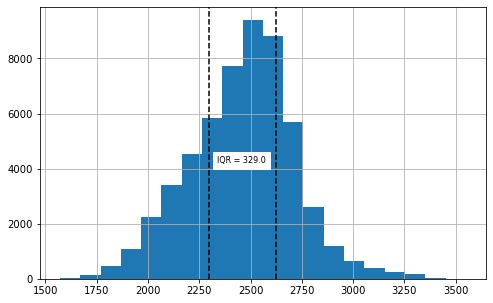

In [240]:
fig, axes = plt.subplots(figsize=(8,5))
df_ranked[df_ranked['Class']=='M'].iloc[:,2:].sum().hist(bins=20)

ax = plt.gca()
ax.axvline(q1, c='black',linestyle='--')
ax.axvline(q3, c='black',linestyle='--')
plt.text(2455,4300, 'IQR = '+str(round(q3-q1,0)), fontsize=8, va='center', ha='center',backgroundcolor='w')
plt.show()